# Galaxy Shear Sims

Contact author: Alex Broughton


## Introduction

- Generate simulation of realistic parametric galaxies using descwl-shear-sims 
- Simulate galaxies with/without silicon sensor effects (incl. the BFE)
- Accurately measure the shapes of the galaxies using metadetect
- Determine the minimum processing requirements to measure the BF induced shear
    distortions on galaxies

## 1.0 Set Up

To begin, let's set up a few packages. Nominally, we will operate using the $\texttt{desc-stack-weekly}$ kernel which should make available most of all lsst tools we will need. In addition, we will need to get the $\texttt{desc-wl-shear}$ package as well as $\texttt{metadetect}$ and a few other supporting packages. 

Since the main branch of each of these reposisitories is not complete enough for our purposes, you must use my own local branches of these packages. In my branch, I have added configurations for the BFE as well as updated it to work with later versions of the LSST Stack. 

As a general practice, I recommend that you create a directory in you home directory called localpackages, and add this to your path. Any code you generate, you can just dump into that directory and install it with $\texttt{pip}$, and you will be able to use anywhere on your system. Once you do this with the additional repositories, you will not need to run it again.

In [4]:
# Import packages:
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

import lsst.afw.image as afw_image
import lsst.afw.geom as afw_geom

In [ ]:
!{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/descwl-shear-sims/descwl-shear-sims --target /global/homes/a/ambrough/localpackages
!{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/descwl_coadd --target /global/homes/a/ambrough/localpackages
!{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/WeakLensingDeblending --target /global/homes/a/ambrough/localpackages
!{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/ngmix --target /global/homes/a/ambrough/localpackages
!{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/metadetect --target /global/homes/a/ambrough/localpackages
!{sys.executable} -m pip install /global/u1/a/ambrough/bfxshear/meds --target /global/homes/a/ambrough/localpackages


In [5]:
# Import local packages:
sys.path.append("/global/homes/a/ambrough/localpackages")
from descwl_shear_sims.galaxies import (make_galaxy_catalog,
                                        FixedGalaxyCatalog,
                                        WLDeblendGalaxyCatalog)
from descwl_shear_sims.stars import make_star_catalog
from descwl_shear_sims.psfs import make_ps_psf, make_fixed_psf
from descwl_shear_sims.sim import get_se_dim, make_sim

%matplotlib inline

In [6]:
# Plotting style
matplotlib.rcParams.update({'font.size': 14})
plt.style.use('tableau-colorblind10')

# Set up some plotting defaults:

params = {'axes.labelsize': 13,
          'font.size': 14,
          'legend.fontsize': 12,
          'xtick.major.width': 1.5,
          'xtick.minor.width': 1,
          'xtick.major.size': 6,
          'xtick.minor.size': 3,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 1.5,
          'axes.linewidth': 1.5,
          'axes.labelweight': 1.5,
          'axes.titleweight': 1.5,
          'ytick.major.width': 1.5,
          'ytick.minor.width': 1,
          'ytick.major.size': 6,
          'ytick.minor.size': 3,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [7, 7],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

## 2.0 Simple Simulation

Simple simulation of galaxies.

*Note: Objects brighter than magntiude 17 (e.g., 14
    since mags are opposite) tend to cause the Rubin Observatory science
    pipeline detection algorithm to misdetect isolted objects in unphysical
    ways. This effect causes the shear response to be non-linear and so
    metadetect will fail. For this reason, you should use the default
    magnitude of 17 or fainter for this kind of galaxy.}*

In [7]:
# Optional: see all config options for make_sim()
make_sim?

Signature:
make_sim(
    *,
    rng,
    galaxy_catalog,
    psf,
    shear_obj=None,
    se_dim=None,
    draw_gals=True,
    star_catalog=None,
    draw_stars=True,
    draw_bright=True,
    psf_dim=51,
    dither=False,
    rotate=False,
    bands=['i'],
    epochs_per_band=1,
    noise_factor=1.0,
    cosmic_rays=False,
    bad_columns=False,
    star_bleeds=False,
    sky_n_sigma=None,
    draw_method='auto',
    calib_mag_zero=30.0,
    survey_name='LSST',
    theta0=0.0,
    g1=None,
    g2=None,
    coadd_dim=None,
    bf_strength=0,
    diffusion_strength=0,
    nrecalc=0,
    verbose=False,
)
Docstring:
Make simulation data

Parameters
----------
rng: numpy.random.RandomState
    Numpy random state
galaxy_catalog: catalog
    E.g. WLDeblendGalaxyCatalog or FixedGalaxyCatalog
shear_obj:
    shear distortion object
psf: GSObject or PowerSpectrumPSF
    The psf object or power spectrum psf
se_dim: int, optional
    Force the single epoch images to have this dimension.  If not
  

In [8]:
%%time
seed = 8312
rng = np.random.RandomState(seed)

coadd_dim = 351

# Make galaxy catalog
galaxy_catalog = FixedGalaxyCatalog(
    rng=rng,
    coadd_dim=coadd_dim,
    buff=0, # Ignored when layout is not 'random'
    layout='grid',
    mag=17,
    hlr=1.0,
)

# Make a constant PSF
psf = make_fixed_psf(psf_type='gauss')

# Generate some simulation data, with a particular shear
sim_data = make_sim(
    rng=rng,
    galaxy_catalog=galaxy_catalog,
    coadd_dim=coadd_dim,
    g1=0.0,
    g2=0,
    psf=psf,
    sky_n_sigma=0.0,
    noise_factor=0.0,
    draw_method="sb",
    bands=['i'],
    star_bleeds=False,
    draw_stars=False,
    draw_gals=True,
    bf_strength=10,
    diffusion_strength=0,
    nrecalc=1,
    verbose=True
)

# Get the first i band exposure
exposure = sim_data['band_data']['i'][0]

# full list of outputs in the dictionary
# sim_data: dict
#     band_data: a dict keyed by band name, holding a list of Exposure
#        objects
#     coadd_wcs: lsst.afw.geom.makeSkyWcs
#     psf_dims: (int, int)
#     coadd_dims: (int, int)
#     coadd_bbox: lsst.geom.Box2I
#     bright_info: structured array
#         fields are
#         ra, dec: sky position of bright stars
#         radius_pixels: radius of mask in pixels
#         has_bleed: bool, True if there is a bleed trail
#     se_wcs: list of WCS

nrecalc for obj #1 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #2 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #3 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #4 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #5 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #6 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #7 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #8 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #9 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #10 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #11 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #12 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #13 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #14 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #15 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #16 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #17 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #18 (z=-1.0, f=158489.3192461114): 1
nrecalc for obj #19 (z=-1.0, f=158489.3192461114): 1
nr

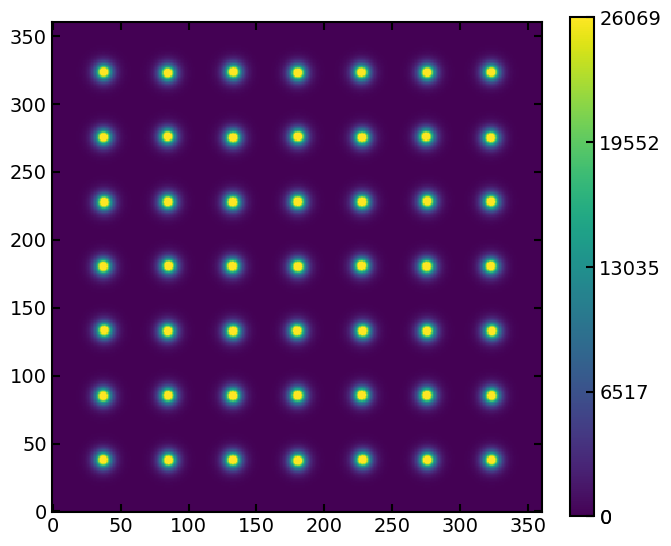

In [9]:
def display_img(data, nticks=5, include_zero=True, center_zero=False, cmap='viridis'):
    import matplotlib.colors as colors
    if center_zero:
        assert np.min(data) < 0
        norm = colors.TwoSlopeNorm(vmin=np.min(data), vcenter=0, vmax=np.max(data))
        im = plt.imshow(data, origin="lower", cmap=cmap, interpolation='nearest', norm=norm)
    else:
        im = plt.imshow(data, origin="lower", cmap=cmap, interpolation='nearest')
    cbar = plt.colorbar(im,fraction=0.046)
    
    cbar_ticks = np.linspace(np.min(data), np.max(data), nticks)
    if include_zero:
        cbar_ticks = np.append(cbar_ticks, 0)

    cbar.set_ticks(cbar_ticks)
    
display_img(sim_data['band_data']['i'][0].getImage().getArray())

## 3.0 BF/no-BF Simulation

In [10]:
def do_sim(bf_on, seed):
    rng = np.random.RandomState(seed)

    coadd_dim = 351

    # Make galaxy catalog
    galaxy_catalog = FixedGalaxyCatalog(
        rng=rng,
        coadd_dim=coadd_dim,
        buff=0, # Ignored when layout is not 'random'
        layout='grid',
        mag=17,
        hlr=1.0,
    )

    # Make a constant PSF
    psf = make_fixed_psf(psf_type='gauss')

    # Generate some simulation data, with a particular shear
    sim_data = make_sim(
        rng=rng,
        galaxy_catalog=galaxy_catalog,
        coadd_dim=coadd_dim,
        g1=0.02,
        g2=0.00,
        psf=psf,
        sky_n_sigma=0.0,
        noise_factor=1.0,
        draw_method="phot",
        bands=['i'],
        star_bleeds=False,
        draw_stars=False,
        draw_gals=True,
        bf_strength=int(bf_on)*1,
        diffusion_strength=0,
        nrecalc=1000
    )

    # Get the first i band exposure
    exposure = sim_data['band_data']['i'][0]
    return exposure

In [11]:
%%time
image_without_bf = do_sim(bf_on=False, seed=8312)

CPU times: user 1.2 s, sys: 60.1 ms, total: 1.26 s
Wall time: 1.2 s


In [12]:
%%time
image_with_bf = do_sim(bf_on=True, seed=8312)

CPU times: user 11 s, sys: 60.1 ms, total: 11.1 s
Wall time: 11 s


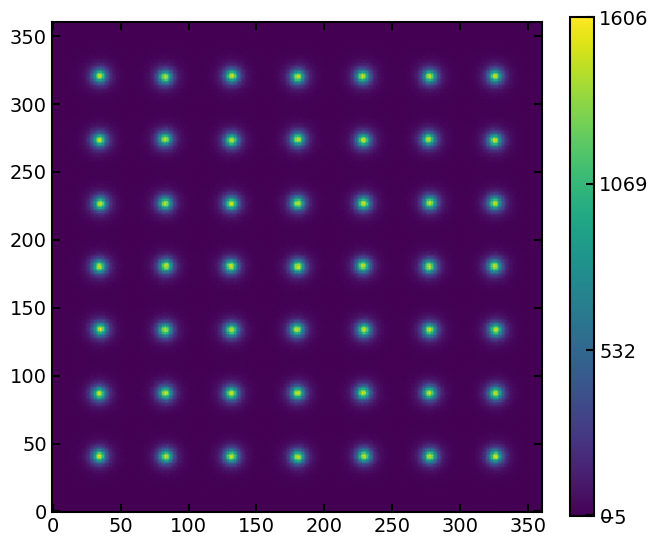

In [13]:
def display_img(data, nticks=5, include_zero=True, center_zero=False, cmap='viridis'):
    import matplotlib.colors as colors
    if center_zero:
        assert np.min(data) < 0
        norm = colors.TwoSlopeNorm(vmin=np.min(data), vcenter=0, vmax=np.max(data))
        im = plt.imshow(data, origin="lower", cmap=cmap, interpolation='nearest', norm=norm)
    else:
        im = plt.imshow(data, origin="lower", cmap=cmap, interpolation='nearest')
    cbar = plt.colorbar(im,fraction=0.046)
    
    cbar_ticks = np.linspace(np.min(data), np.max(data), nticks)
    if include_zero:
        cbar_ticks = np.append(cbar_ticks, 0)

    cbar.set_ticks(cbar_ticks)
display_img(image_with_bf.getImage().getArray(), nticks=4)

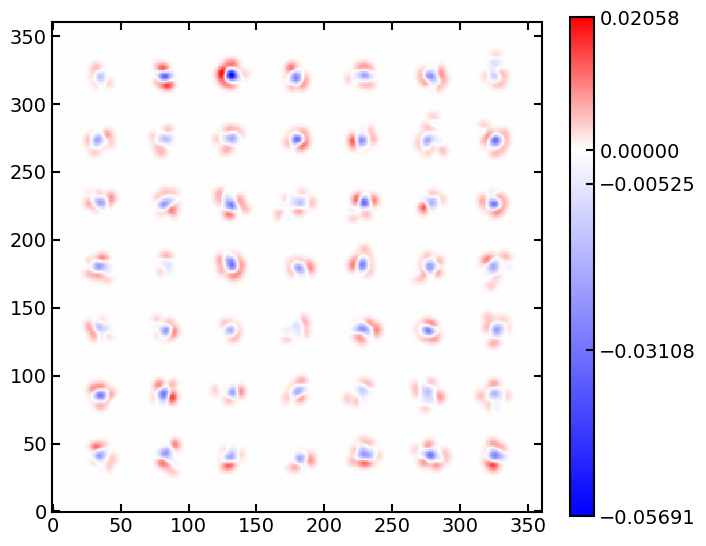

In [14]:
diff = (image_with_bf.getImage().getArray() - image_without_bf.getImage().getArray())
display_img(gaussian_filter(diff,3), nticks=4, center_zero=True, cmap='bwr')

## 4.0 Run Metadetect

This instruction is based on an example courtesy of Erin Sheldon.

The steps to convert these exposures into something useable by metadetect are:

**1. Co-add exposures in the same filter band.**

*Note: You can use one single exposure in one filter band, but you still need to convert it into these objects. In that case you would co-add them with the no-warp option as there is no need for resampling to combine images from multiple visits.*

**2. Combine all co-adds into a muliband co-add object**

The output object will contain:
```
mbexp: lsst.afw.image.MultibandExposure
    The exposure(s) to process
noise_mbexp: lsst.afw.image.MultibandExposure
    The noise exposures for metacal
mfrac_mbexp: lsst.afw.image.MultibandExposure, optional
    The fraction of masked exposures for the pixel; for coadds this is the
    fraction of input images contributing to each pixel that were masked
ormasks: list of images, optional
    A list of logical or masks, such as created for all images that went
    into a coadd.
```

**3. Run $\texttt{metadetect}$.**

*Note: I have configured metadetect to output 3 different catalogs: 'noshear', '1p', '1m'. These correspond to the true measured statistics, the statisitics with one small positive step of added shear, and the statistics with one small negative step of added shear. The difference $(1p - 1m) / (2*step)$ approximates the jacobian shear response.*

### 4.1 Set Up

In [4]:
from descwl_coadd.coadd import make_coadd
from descwl_coadd.coadd_nowarp import make_coadd_nowarp
from metadetect.lsst.util import extract_multiband_coadd_data
from metadetect.lsst.metadetect import run_metadetect
import copy

In [8]:
def _prepare_data_one_exp(rng, sim_data, remove_poisson, nowarp=True):
    """
    Coadd + combine into mulitband coadd object for metadetect.
    Although, here we only "coadd" 1 exposure in 1 band.
    
    copied from mdet-lsst-sim by Matt Becker
    """
    
    bands = list(sim_data['band_data'].keys())

    # Warping is the process of reprojecting, and resampling images
    # to be coadded. However, here we are only coadding one exposure,
    # (potentially in multiple bands, though) so we only need to use
    # the make_coadd_cowarp() function.
    exps = sim_data['band_data'][bands[0]]

    if len(exps) > 1:
        raise ValueError('Only one epoch for nowarp')

    exp = exps[0]

    # Optional: adjust the PSF that gets used to measure the objects
    # in the image
    exp.getPsf()._gspsf.dilate(2)
    
    coadd_data_list = [
        make_coadd_nowarp(
            exp=exp,
            psf_dims=sim_data['psf_dims'],
            rng=rng,
            remove_poisson=remove_poisson,
        )
        for band in bands
    ]

    return extract_multiband_coadd_data(coadd_data_list)

### 4.2 Run $\texttt{metadetect}$

In [9]:
coadd_data = _prepare_data_one_exp(rng, sim_data, remove_poisson=True)

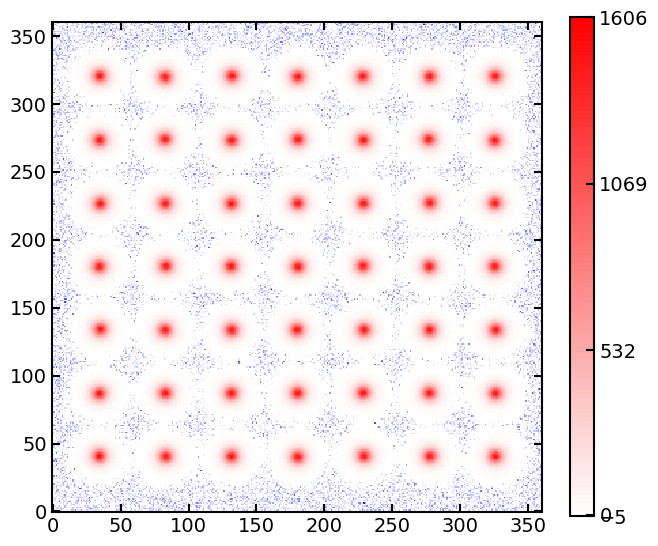

In [10]:
# Multiband exposure
display_img(coadd_data['mbexp'].image.array[0], nticks=4, center_zero=True, cmap='bwr')

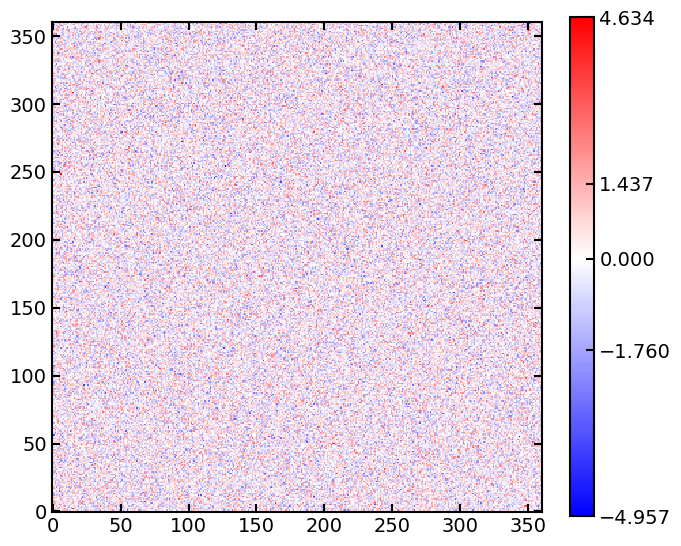

In [11]:
# Noise image (to be subtracted from exposure)
display_img(coadd_data['noise_mbexp'].image.array[0], nticks=4, center_zero=True, cmap='bwr')

In [12]:
# Set the configuration parameters for metadetect.

# Because our noise here is very small, our S/N ratios of our galaxies are > 4000, 
# so a detection threshold of 3 sigma is good enough. But this parameter might need 
# to be adjusted if you want to probe fainter galaxies

CONFIG = {
    "meas_type": "wmom",
    "metacal": {
        "use_noise_image": True,
        "psf": "fitgauss",
    },
    "psf": {
        "model": "gauss",
        "lm_pars": {},
        "ntry": 2,
    },
    "weight": {
        "fwhm": 0.7,
    },
    "detect": {
        "thresh": 3.0,
    },
}

In [13]:
# Set the random seed for metadetect. 

# Metadetect uses this to randomly sample the 
# response of ellipticity to shear.

mdet_seed = rng.randint(low=1, high=2**29)
mdet_rng = np.random.RandomState(seed=mdet_seed)

In [ ]:
# Run it!

results = run_metadetect(
        rng=mdet_rng,
        config=copy.deepcopy(CONFIG),
        **coadd_data,
)

In [14]:
# Here is what the example output looks like for a single catalog:


results['noshear'][0].dtype.fields

mappingproxy({'wmom_flags': (dtype('int32'), 0),
              'wmom_psf_flags': (dtype('int32'), 4),
              'wmom_psf_g': (dtype(('<f8', (2,))), 8),
              'wmom_psf_T': (dtype('float64'), 24),
              'wmom_obj_flags': (dtype('int32'), 32),
              'wmom_s2n': (dtype('float64'), 36),
              'wmom_g': (dtype(('<f8', (2,))), 44),
              'wmom_g_cov': (dtype(('<f8', (2, 2))), 60),
              'wmom_T': (dtype('float64'), 92),
              'wmom_T_flags': (dtype('int32'), 100),
              'wmom_T_err': (dtype('float64'), 104),
              'wmom_T_ratio': (dtype('float64'), 112),
              'wmom_band_flux_flags': (dtype('int32'), 120),
              'wmom_band_flux': (dtype('float64'), 124),
              'wmom_band_flux_err': (dtype('float64'), 132),
              'shear_bands': (dtype('<U6'), 140),
              'stamp_size': (dtype('int32'), 164),
              'row0': (dtype('int32'), 168),
              'col0': (dtype('int32'), 172)

In [26]:
def fit_gauss(data, x=None):
    # Fit a gaussian function to the data
    import scipy.stats
    
    #bins = np.histogram_bin_edges(data, bins=10)
    mu, sigma = scipy.stats.norm.fit(data)
    #mu = np.mean(data)
    #sigma = np.std(data)
    #if x==None:
    #    x=np.linspace(-0.004, 0.008)
    y = scipy.stats.norm.pdf(x, mu, sigma)
    
    return x, y

(-0.004, 0.01)

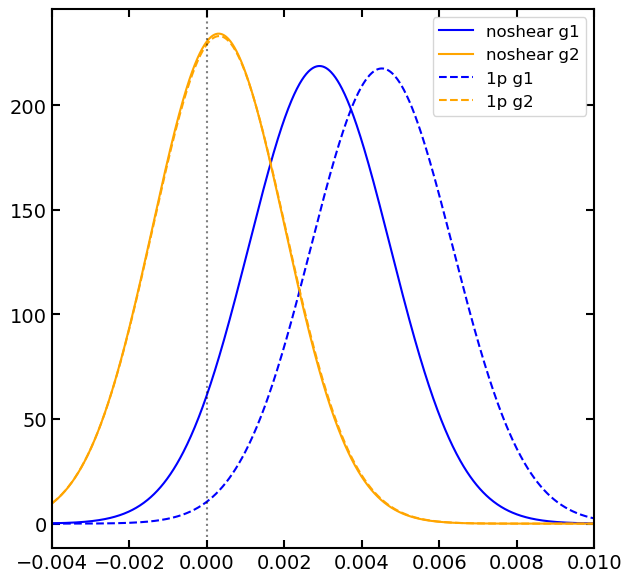

In [79]:
#_ = plt.hist(results['noshear']['wmom_g'][:,0].ravel(), density=True, color='blue', alpha=0.5)
x, y = fit_gauss(results['noshear']['wmom_g'][:,0].ravel())
plt.plot(x, y, color='blue', linestyle="-", label = "noshear g1")
#_ = plt.hist(results['noshear']['wmom_g'][:,1].ravel(), density=True, color='orange', alpha=0.5)
x, y = fit_gauss(results['noshear']['wmom_g'][:,1].ravel())
plt.plot(x, y, color='orange', linestyle="-", label = "noshear g2")

#_ = plt.hist(results['1p']['wmom_g'][:,0].ravel(), density=True, histtype='step', color='blue')
x, y = fit_gauss(results['1p']['wmom_g'][:,0].ravel())
plt.plot(x, y, color='blue', linestyle="--", label = "1p g1")
#_ = plt.hist(results['1p']['wmom_g'][:,1].ravel(), density=True, histtype='step', color='orange')
x, y = fit_gauss(results['1p']['wmom_g'][:,1].ravel())
plt.plot(x, y, color='orange', linestyle="--", label = "1p g2")

plt.axvline(0., linestyle=":", color="k", alpha=0.5)
plt.legend()
plt.xlim(-.004, .01)


https://github.com/LSSTDESC/descwl-shear-sims/blob/master/shear_meas_tests/test_shear_meas.py


## 5.0 Run Many Sims

I have run a few trials of many sims to gauge how many statistics will be needed to measure the BFE on galaxies.

Test Trials:
```
- For ntrials=9800, nrecalc=10, noise_factor = 1.0, bf_strength = 1
    z     =   3.5423090464226092e-06
    zerr  =   1.8486762636470338e-05

- For ntrials=9800, nrecalc=1000, noise_factor = 1.0, bf_strength = 1
    z     =   3.462521912356298e-06
    zerr  =   1.8486868452044042e-05

- For ntrials=9800, nrecalc=1000, noise_factor = .5, bf_strength = 1
    z     =   3.495309986667472e-06
    zerr  =   1.8451610891728408e-05
    
- For ntrials=9800, nrecalc=1000, noise_factor = .5, bf_strength = 10
    mu_withbf    = 0.36529110505508533
    mu_nobf      = 0.36525545431973117
    muerr_withbf = 1.3037712991711596e-05
    muerr_nobf   = 1.304893325140027e-05
    z            = 3.565073535416463e-05
    zerr         = 1.8446046163168543e-05
    zerr/z       = 51.74099770992163%
    (6 min, njobs=4)

- For ntrials=9800, nrecalc=10, noise_factor = .5, bf_strength = 10
    mu_withbf    = 0.3652911269141014
    mu_nobf      = 0.36525545431973117
    muerr_withbf = 1.3037803815026742e-05
    muerr_nobf   = 1.304893325140027e-05
    z            = 3.567259437026182e-05
    zerr         = 1.8446110357433772e-05
    zerr/z       = 51.7094724481582%
    (51 min, njobs=4)
```

In [75]:
import time
import copy
import numpy as np
import tqdm
import joblib

import pytest

from metadetect.lsst.metadetect import run_metadetect
import descwl_shear_sims as sim
from descwl_shear_sims.shear import ShearConstant

shear_obj_p = ShearConstant(g1=0.02, g2=0.)
shear_obj_m = ShearConstant(g1=-0.02, g2=0.)

CONFIG = {
    "meas_type": "wmom",
    "metacal": {
        "use_noise_image": True,
        "psf": "fitgauss",
    },
    "psf": {
        "model": "gauss",
        "lm_pars": {},
        "ntry": 2,
    },
    "weight": {
        "fwhm": 1.2,
    },
    "detect": {
        "thresh": 10.0,
    },
}


def _make_lsst_sim(bf_on, rng):

    coadd_dim = 351

    # Make galaxy catalog
    galaxy_catalog = FixedGalaxyCatalog(
        rng=rng,
        coadd_dim=coadd_dim,
        buff=0, # Ignored when layout is not 'random'
        layout='grid',
        mag=18,
        hlr=1.0,
    )

    # Make a constant PSF
    psf = make_fixed_psf(psf_type='gauss')

    # Generate some simulation data, with a particular shear
    sim_data = make_sim(
        rng=rng,
        galaxy_catalog=galaxy_catalog,
        coadd_dim=coadd_dim,
        g1=0.00,
        g2=0.00,
        psf=psf,
        sky_n_sigma=0.0,
        noise_factor=.5,
        draw_method="phot",
        bands=['i'],
        star_bleeds=False,
        draw_stars=False,
        draw_gals=True,
        bf_strength=int(bf_on)*1,
        diffusion_strength=0,
        nrecalc=1000,
        verbose=False
    )

    return sim_data


def _coadd_sim_data(rng, sim_data, nowarp, remove_poisson):
    """
    copied from mdet-lsst-sim
    """
    from descwl_coadd.coadd import make_coadd
    from descwl_coadd.coadd_nowarp import make_coadd_nowarp
    from metadetect.lsst.util import extract_multiband_coadd_data

    bands = list(sim_data['band_data'].keys())

    if nowarp:
        exps = sim_data['band_data'][bands[0]]

        if len(exps) > 1:
            raise ValueError('only one epoch for nowarp')
            
        exp = exps[0]

        # Optional: adjust the PSF that gets used to measure the objects
        # in the image
        exp.getPsf()._gspsf.dilate(2)

        coadd_data_list = [
            make_coadd_nowarp(
                exp=exp,
                psf_dims=sim_data['psf_dims'],
                rng=rng,
                remove_poisson=remove_poisson,
            )
            for band in bands
        ]
    else:
        coadd_data_list = [
            make_coadd(
                exps=sim_data['band_data'][band],
                psf_dims=sim_data['psf_dims'],
                rng=rng,
                coadd_wcs=sim_data['coadd_wcs'],
                coadd_bbox=sim_data['coadd_bbox'],
                remove_poisson=remove_poisson,
            )
            for band in bands
        ]
    return extract_multiband_coadd_data(coadd_data_list)


def _run_sim_one(*, bf_on, seed, mdet_seed):
    rng = np.random.RandomState(seed=seed)
    sim_data = _make_lsst_sim(bf_on=bf_on, rng=rng)

    coadd_data = _coadd_sim_data(
        rng=rng, sim_data=sim_data, nowarp=True, remove_poisson=False,
    )

    mdet_rng = np.random.RandomState(seed=mdet_seed)
    results = run_metadetect(
        rng=mdet_rng,
        config=copy.deepcopy(CONFIG),
        **coadd_data,
    )

    return results


def run_sim(bf_on, seed, mdet_seed, **kwargs):
    # positive shear
    res = _run_sim_one(bf_on= bf_on,
        seed=seed, mdet_seed=mdet_seed,
    )
    
    T = res['noshear']['wmom_T'].ravel()
    T_psf = res['noshear']['wmom_psf_T'].ravel()
    

    return T,T_psf


@pytest.mark.parametrize(
    'layout,ntrial', [('grid', 500), ('random', 2500)]
)
def test_shear_meas(bf_on, ntrial):
    nsub = max(ntrial // 100, 10)
    nitr = ntrial // nsub
    print("Running jobs")
    print(f"ntrial: {ntrial}, nsub: {nsub}, nitr: {nitr}\n")
    
    rng = np.random.RandomState(seed=116)
    seeds = rng.randint(low=1, high=2**29, size=ntrial)
    mdet_seeds = rng.randint(low=1, high=2**29, size=ntrial)

    g1 = []
    g2 = []
    loc = 0
    # Run run_sim() on ntrials, submitting in nitr batches of size nsub
    for itr in tqdm.trange(nitr, colour="green"):
        # For each itr, submit nsub jobs
        # Pass it different seeds each time
        jobs = [
            joblib.delayed(run_sim)(
                bf_on, seeds[loc+i], mdet_seeds[loc+i],
            )
            for i in range(nsub)
        ]
        
        # outputs has length nsub 
        outputs = joblib.Parallel(n_jobs=1, verbose=0, backend='loky')(jobs)

        for out in outputs:
            if out is None:
                # This job has failed, check the next one
                continue
            g1.extend(out[0])
            g2.extend(out[1])

        loc += nsub

    return g1, g2



In [ ]:
T_nobf, T_psf_nobf = test_shear_meas(bf_on=False, ntrial=200)

In [76]:
T_withbf, T_psf_withbf = test_shear_meas(bf_on=True, ntrial=400)

Running jobs
ntrial: 400, nsub: 10, nitr: 40



  5%|▌         | 2/40 [02:55<55:29, 87.62s/it]

KeyboardInterrupt



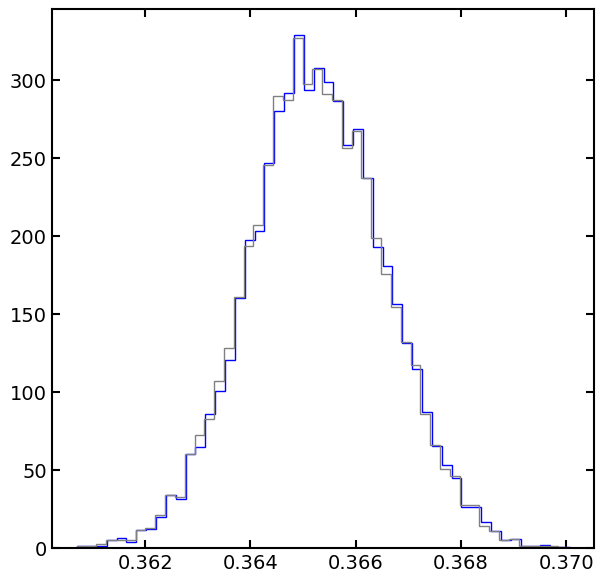

In [67]:
_ = plt.hist(T_withbf, bins=50, color="blue", density=True, histtype="step")
#x, y = fit_gauss(T_withbf, x=np.linspace(0.36435,0.3646, 1000))
#plt.plot(x, y, color='blue', linestyle="--")

_ = plt.hist(T_nobf, bins=50, color="gray", density=True, histtype="step")
#x, y = fit_gauss(T_nobf, x=np.linspace(0.36435,0.3646, 1000))
#plt.plot(x, y, color='gray', linestyle="--")

#_ = plt.hist(T_psf_withbf)


In [68]:
mu_withbf = np.mean(T_withbf)
mu_nobf   = np.mean(T_nobf)
muerr_withbf = np.std(T_withbf) / np.sqrt(len(T_withbf))
muerr_nobf = np.std(T_nobf) / np.sqrt(len(T_nobf))
z = mu_withbf - mu_nobf
zerr = np.sqrt(muerr_withbf**2 + muerr_nobf**2)

In [70]:
print(
    f"mu_withbf    = {mu_withbf}\n"
    f"mu_nobf      = {mu_nobf}\n"
    f"muerr_withbf = {muerr_withbf}\n"
    f"muerr_nobf   = {muerr_nobf}\n"
    f"z            = {z}\n"
    f"zerr         = {zerr}\n"
    f"zerr/z       = {100*(zerr/z)}%"
)

mu_withbf    = 0.3652911269141014
mu_nobf      = 0.36525545431973117
muerr_withbf = 1.3037803815026742e-05
muerr_nobf   = 1.304893325140027e-05
z            = 3.567259437026182e-05
zerr         = 1.8446110357433772e-05
zerr/z       = 51.7094724481582%
